In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
dataset = pd.read_csv("heart_disease_uci.csv")

In [10]:
dataset['num'] = dataset['num'].apply(lambda x: 1 if x> 0 else 0)

Required preprocessing steps from previous notebooks

In [11]:
# Handling trestbps outlier
print("Outlier in trestbps feature: ") # all of these outlier findings has been done in previous notebooks
print(dataset[dataset['trestbps']==0])
dataset['trestbps'] = dataset['trestbps'].replace(0, np.nan)
print(dataset['trestbps'].min(skipna = True))

# Handling oldpeak outlier
print("Outlier in oldpeak feature")
print(len(dataset[dataset['oldpeak'] <0]))
dataset['oldpeak']  = dataset['oldpeak'].clip(lower = 0, upper = 6)
print(len(dataset[dataset['oldpeak'] <0]))

# Splitting the dataset
X = dataset.iloc[:,1:-1]
y = dataset.iloc[: , -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("\nNumeric Features are: ")
print(dataset.select_dtypes(include=[np.number]).columns.tolist())

# Transformations

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
num_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')),
        ('scaler', StandardScaler())
    ]
)
cat_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('encoder', OneHotEncoder(drop = 'first'))
    ]
)
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ]
)

# Applying transformations

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print("After transformation, dataset is: ")
print(X_train[:5])
print(X_train.shape)

# creating a map

feature_names = (num_features +
                 list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)))

X_df = pd.DataFrame(X_train, columns = feature_names)
print(X_df.info())

Outlier in trestbps feature: 
      id  age   sex        dataset           cp  trestbps  chol    fbs  \
753  754   55  Male  VA Long Beach  non-anginal       0.0   0.0  False   

    restecg  thalch  exang  oldpeak slope  ca thal  num  
753  normal   155.0  False      1.5  flat NaN  NaN    1  
80.0
Outlier in oldpeak feature
12
0

Numeric Features are: 
['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
After transformation, dataset is: 
[[ 9.02412547e-01  1.57774920e-15 -2.54935123e-01 -6.88473319e-01
   2.00217983e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 3.47761857e-02  1.00702194e+00  0.00000000e+00 -6.09262363e-01
  -8.55320196e-01  1.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.0000000

In [12]:

X_test_df = pd.DataFrame(X_test, columns = feature_names)
print(X_test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       184 non-null    float64
 1   trestbps                  184 non-null    float64
 2   chol                      184 non-null    float64
 3   thalch                    184 non-null    float64
 4   oldpeak                   184 non-null    float64
 5   sex_Male                  184 non-null    float64
 6   cp_atypical angina        184 non-null    float64
 7   cp_non-anginal            184 non-null    float64
 8   cp_typical angina         184 non-null    float64
 9   fbs_True                  184 non-null    float64
 10  restecg_normal            184 non-null    float64
 11  restecg_st-t abnormality  184 non-null    float64
 12  exang_True                184 non-null    float64
 13  slope_flat                184 non-null    float64
 14  slope_upsl

Loading trained models for shap evaluation

In [13]:
import joblib

dt = joblib.load("dt.pkl")
log_reg = joblib.load("log_reg.pkl")
rf = joblib.load("rf.pkl")
xgb_model = joblib.load("xgb_model.pkl")

SHAP EVALUATION

In [14]:
import shap

SHAP summary beeswarm plot

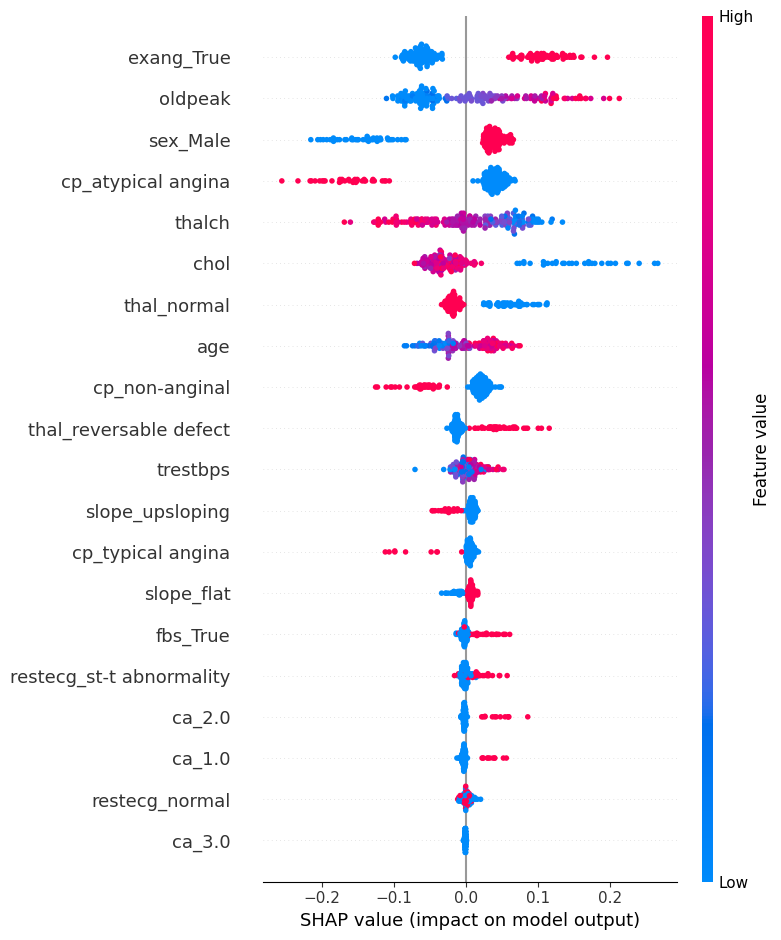

'\nX-axis (SHAP value): The impact of that feature on the model’s output (positive → pushes prediction toward “disease”, negative → pushes prediction toward “no disease”).\nEach dot: A single patient from your test set.\n\nColor of dots: The feature value for that patient (blue = low, red = high).\n\nSo this plot is feature importance + direction + interaction with value scale, all in one.\n\n2. How to interpret it\n\nFeature importance: Features at the top are most impactful (sorted automatically).\n👉 Here, exang_True, oldpeak, and sex_Male are the biggest drivers of predictions.\n\nImpact direction:\n\nExample:\n\nHigh oldpeak values (red dots) are on the right (positive SHAP) → high oldpeak increases chance of heart disease.\n\nLow oldpeak values (blue dots) are on the left (negative SHAP) → low oldpeak decreases risk.\n\nFor thalch (max heart rate): red dots (high heart rate) push left → higher max heart rate reduces predicted risk.\n\nSpread: Wider spread along the x-axis means th

In [15]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)

# Select class 1 (positive class) along the last axis
shap_values_rf_class1 = shap_values_rf[:, :, 1]

# Now plot
shap.summary_plot(shap_values_rf_class1, X_test, feature_names=feature_names)

"""
X-axis (SHAP value): The impact of that feature on the model’s output (positive → pushes prediction toward “disease”, negative → pushes prediction toward “no disease”).
Each dot: A single patient from your test set.

Color of dots: The feature value for that patient (blue = low, red = high).

So this plot is feature importance + direction + interaction with value scale, all in one.

2. How to interpret it

Feature importance: Features at the top are most impactful (sorted automatically).
👉 Here, exang_True, oldpeak, and sex_Male are the biggest drivers of predictions.

Impact direction:

Example:

High oldpeak values (red dots) are on the right (positive SHAP) → high oldpeak increases chance of heart disease.

Low oldpeak values (blue dots) are on the left (negative SHAP) → low oldpeak decreases risk.

For thalch (max heart rate): red dots (high heart rate) push left → higher max heart rate reduces predicted risk.

Spread: Wider spread along the x-axis means the feature varies more in how much it influences predictions.
"""


In [16]:
print(shap_values_rf_class1)

[[-0.0333862  -0.00478645 -0.04181632 ... -0.00130811 -0.02566015
  -0.01549236]
 [-0.06074501 -0.01379724 -0.05482701 ... -0.00183836 -0.01797755
  -0.01098413]
 [-0.00032979  0.03092897 -0.02089012 ... -0.00112403 -0.00919778
  -0.00658019]
 ...
 [ 0.00299617 -0.01788832 -0.07202457 ... -0.001888   -0.01799545
  -0.01459038]
 [ 0.02675472 -0.01265626 -0.0313195  ... -0.00154863 -0.02493609
  -0.0119919 ]
 [ 0.02456762 -0.01010124  0.16432412 ... -0.00106443 -0.0090008
  -0.00665339]]


In [17]:
shap_values_rf[0].shape

(20, 2)

In [18]:
shap_values_rf.shape

(184, 20, 2)

In [19]:
print(rf.classes_)
print(shap_values_rf[0].shape, shap_values_rf[1].shape)
print(X_test_df.shape)

[0 1]
(20, 2) (20, 2)
(184, 20)


Feature Importance Table:
                 Feature  Mean |SHAP|  Rank
              exang_True     0.080648    13
                 oldpeak     0.066932     5
                sex_Male     0.064649     6
      cp_atypical angina     0.063924     7
                  thalch     0.053436     4
                    chol     0.053223     3
             thal_normal     0.031964    19
                     age     0.031771     1
          cp_non-anginal     0.030672     8
  thal_reversable defect     0.021826    20
                trestbps     0.012220     2
         slope_upsloping     0.011252    15
       cp_typical angina     0.008404     9
              slope_flat     0.008273    14
                fbs_True     0.007354    10
restecg_st-t abnormality     0.006040    12
                  ca_2.0     0.005774    17
                  ca_1.0     0.005569    16
          restecg_normal     0.003626    11
                  ca_3.0     0.001452    18


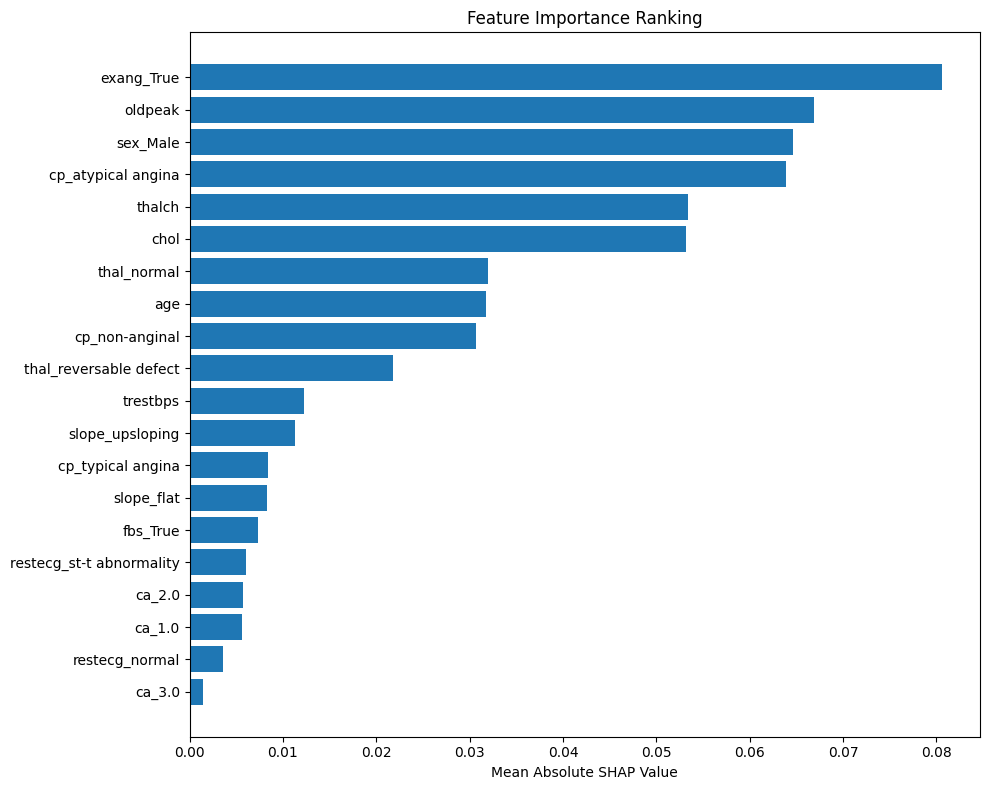

In [20]:
# Calculate and display feature importance as a table
mean_abs_shap = np.abs(shap_values_rf_class1).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean |SHAP|': mean_abs_shap,
    'Rank': range(1, len(feature_names) + 1)
}).sort_values('Mean |SHAP|', ascending=False)

print("Feature Importance Table:")
print(feature_importance_df.to_string(index=False))

# Optional: Plot as horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Mean |SHAP|'])
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()
plt.show()

SHAP on XGBOOst

Shape of shap_values_xgb: (184, 20)


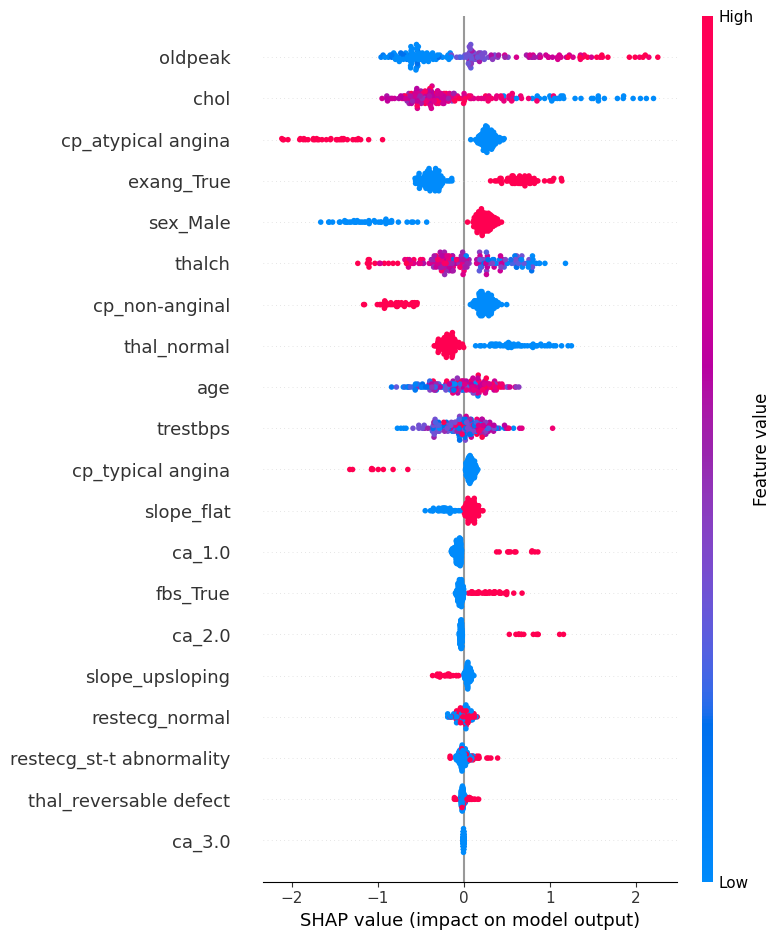

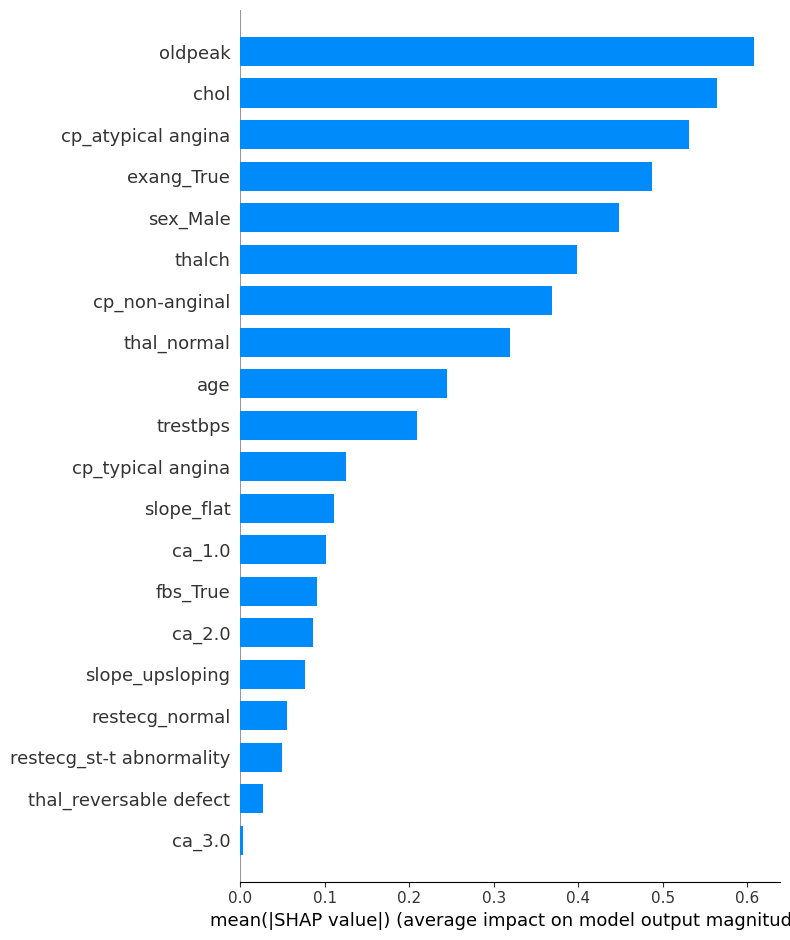

In [21]:
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

print(f"Shape of shap_values_xgb: {shap_values_xgb.shape}")
# Beeswarm plot
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names)

# Bar plot (just importance)
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names, plot_type="bar")


In [24]:
# Calculate numerical feature importance values
mean_abs_shap = np.abs(shap_values_xgb).mean(axis=0)

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_ABS_SHAP': mean_abs_shap,
    'Rank': range(1, len(feature_names) + 1)
}).sort_values('Mean_ABS_SHAP', ascending=False)

print("\n" + "="*50)
print("XGBoost Feature Importance Ranking:")
print("="*50)
print(feature_importance_df.to_string(index=False))

# Additional: Show the expected value
print(f"\nExpected value (base value): {explainer_xgb.expected_value}")


XGBoost Feature Importance Ranking:
                 Feature  Mean_ABS_SHAP  Rank
                 oldpeak       0.608369     5
                    chol       0.564626     3
      cp_atypical angina       0.530774     7
              exang_True       0.487270    13
                sex_Male       0.448436     6
                  thalch       0.398119     4
          cp_non-anginal       0.369612     8
             thal_normal       0.318862    19
                     age       0.244340     1
                trestbps       0.209258     2
       cp_typical angina       0.125179     9
              slope_flat       0.111660    14
                  ca_1.0       0.102064    16
                fbs_True       0.090756    10
                  ca_2.0       0.085811    17
         slope_upsloping       0.076439    15
          restecg_normal       0.055025    11
restecg_st-t abnormality       0.049054    12
  thal_reversable defect       0.027646    20
                  ca_3.0       0.003590    

SHAP on Decision Tree

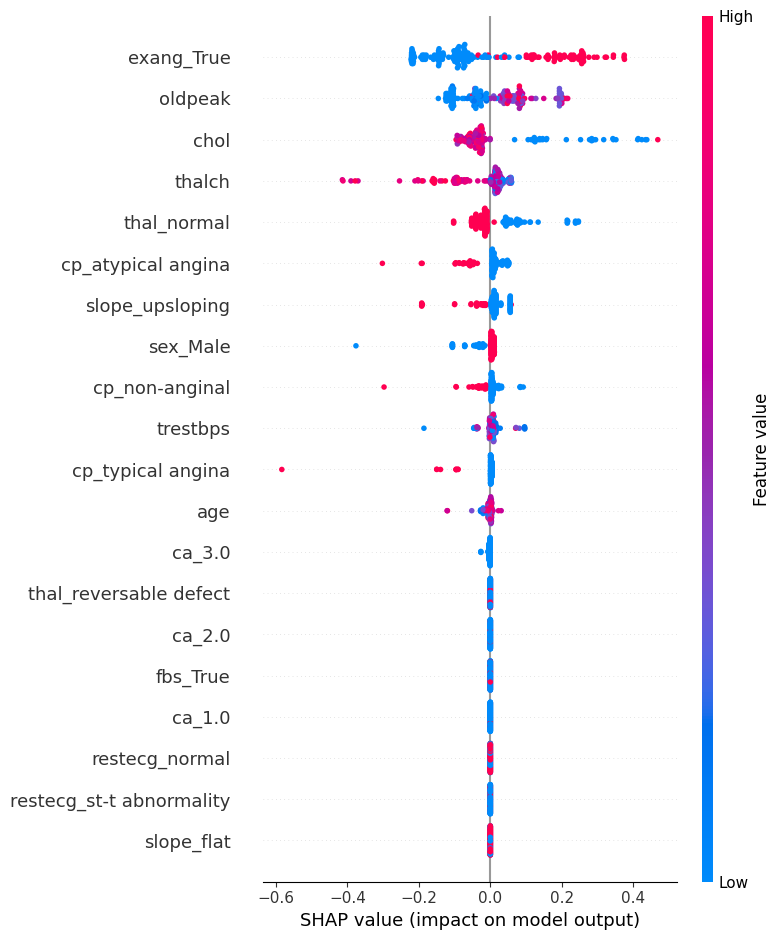

In [22]:
explainer_dt = shap.TreeExplainer(dt)
shap_values_dt = explainer_dt.shap_values(X_test)

# Select class 1 (positive class) along the last axis
shap_values_dt_class1 = shap_values_dt[:, :, 1]

# Now plot
shap.summary_plot(shap_values_dt_class1, X_test, feature_names=feature_names)

SHAP on Logistic Regression

Shape: (184, 20)


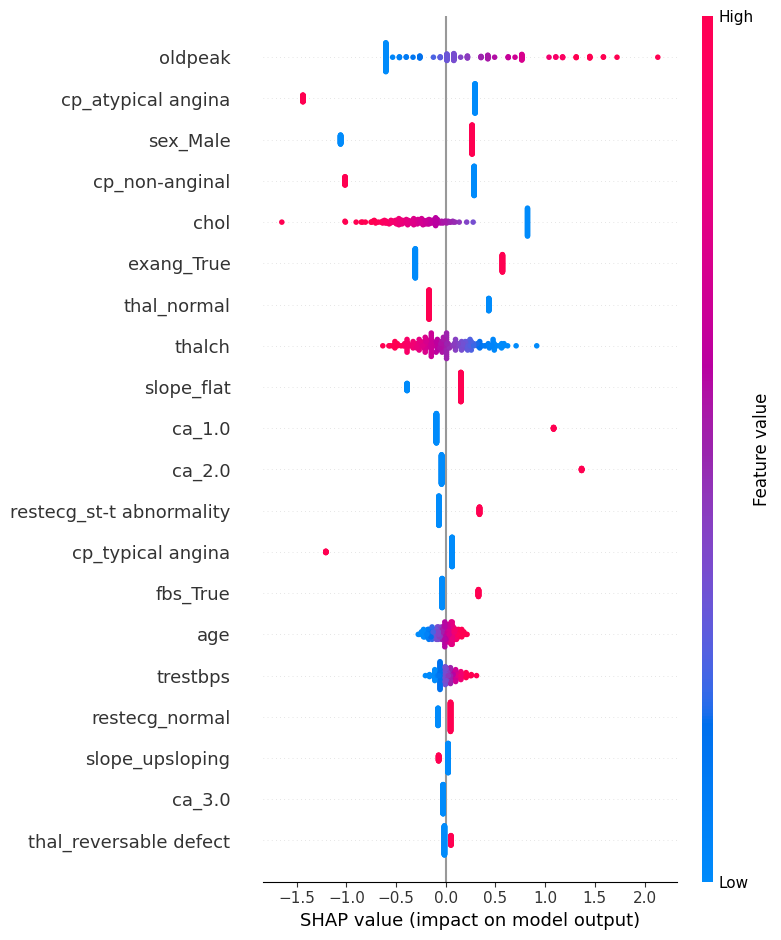

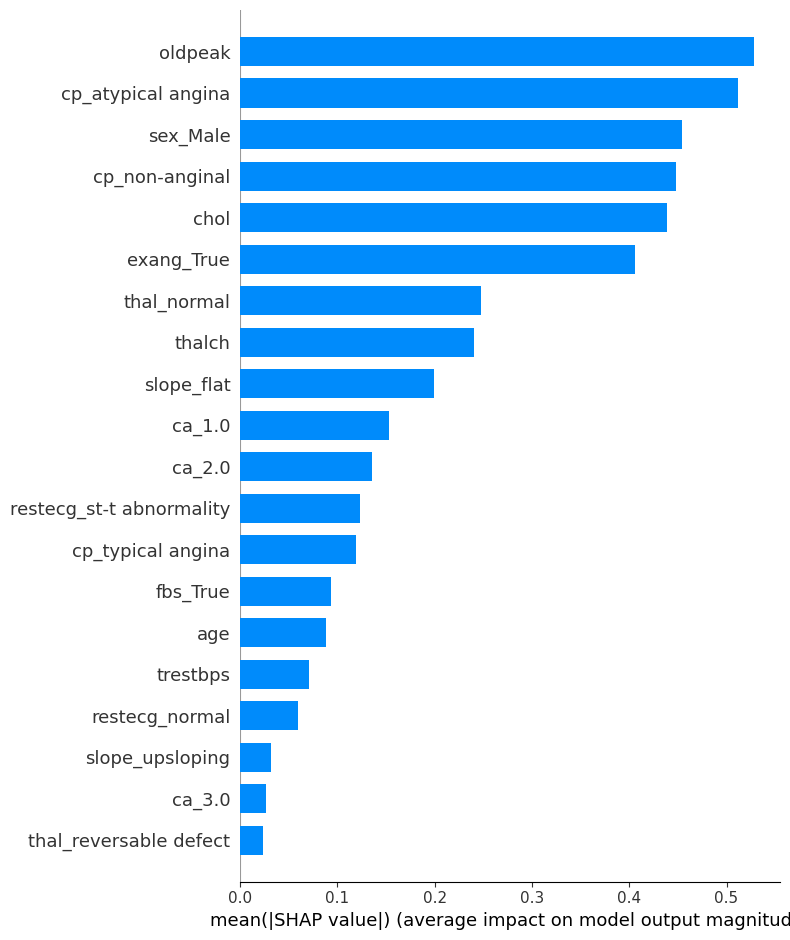

In [23]:
explainer_lr = shap.LinearExplainer(log_reg, X_train, feature_names=feature_names)
shap_values_lr = explainer_lr.shap_values(X_test)

print("Shape:", shap_values_lr.shape)  # should be (n_samples, n_features)

# Beeswarm plot
shap.summary_plot(shap_values_lr, X_test, feature_names=feature_names)

# Bar plot
shap.summary_plot(shap_values_lr, X_test, feature_names=feature_names, plot_type="bar")
